<h1>Plate plotter</h1>

The following notebook reads your extracted in-focus images folder and plots them in a grid like fashion according to their original position in the plate (well_id). Once you run this notebook you can find the plate images under <code>./output/output_plot.png</code>

You can also plot your resulting object segmentations and visualize them along the entire plate in Napari.

In [ ]:
from utils import plot_plate, random_cmap, segment_organoids, save_object_mask, segment_in_focus_organoids
from pathlib import Path
import tifffile
import napari
from napari.utils import nbscreenshot
from matplotlib.colors import ListedColormap

# Initialize GPU-acceleration if available
import pyclesperanto_prototype as cle  # version 0.24.1
device = cle.select_device("TX")
print("Used GPU: ", device)

You can modify the resolution at which the output plate image is stored (by default 300 dpi, you can increase it according to your needs). Remember the higher dpi the higher space in disk.

In [ ]:
# Define the resolution at which you want to plot your plates
plot_resolution=300

6it [00:00, 22.93it/s]
6it [00:00, 25.57it/s]
6it [00:00, 27.63it/s]
6it [00:00, 22.48it/s]


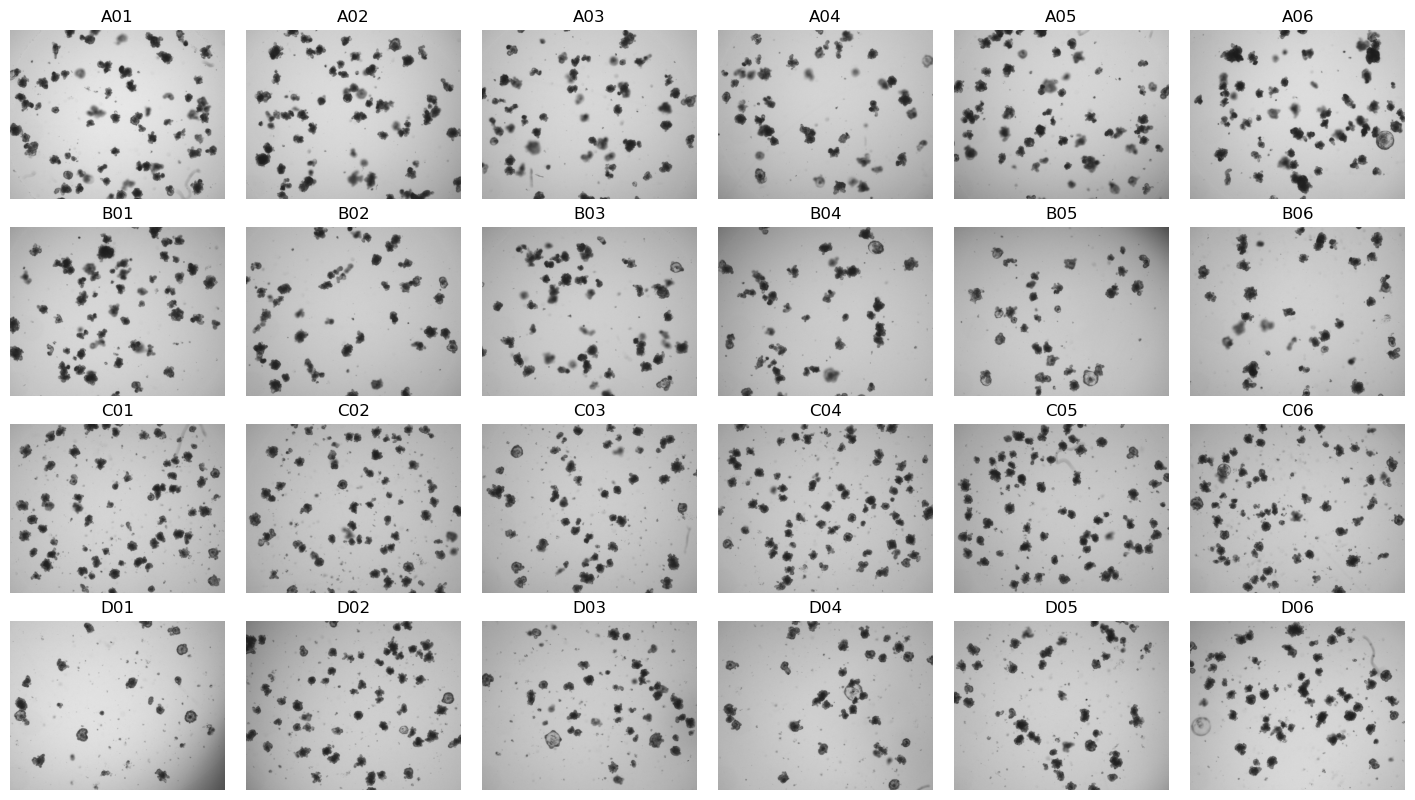

In [2]:
plot_plate(
    resolution=plot_resolution,
    output_path="./output/organoid_greyscale_plot.tif",
    img_folder_path="./output/in_focus_organoids/",
    )

<h2>Label visualization</h2>

You can also apply the trained classifiers for organoid object and organoid in-focus detection to visualize them in the same grid-like fashion

In [ ]:
# Define the directory path where your in-focus organoid z-stack have been stored ("./output/in_focus_organoids/" by default)
in_focus_organoids = Path("./output/in_focus_organoids/")

# segment_organoids() returns a dictionary where the organoid labels are stored under each well_id key
segmented_organoids = segment_organoids(in_focus_organoids)

In [ ]:
# Define the directory path where you want to save the segmented organoid masks
output_directory = "./output/segmented_organoids/"

# Save the segmented organoid masks contained in segmented_organoids in the above defined output directory
save_object_mask(segmented_organoids, output_directory)

By running the cell below you can visualize the segmented organoid mask in the same plateview as the greyscale images.

6it [00:00, 105.40it/s]
6it [00:00, 91.00it/s]
6it [00:00, 91.73it/s]
6it [00:00, 98.17it/s]


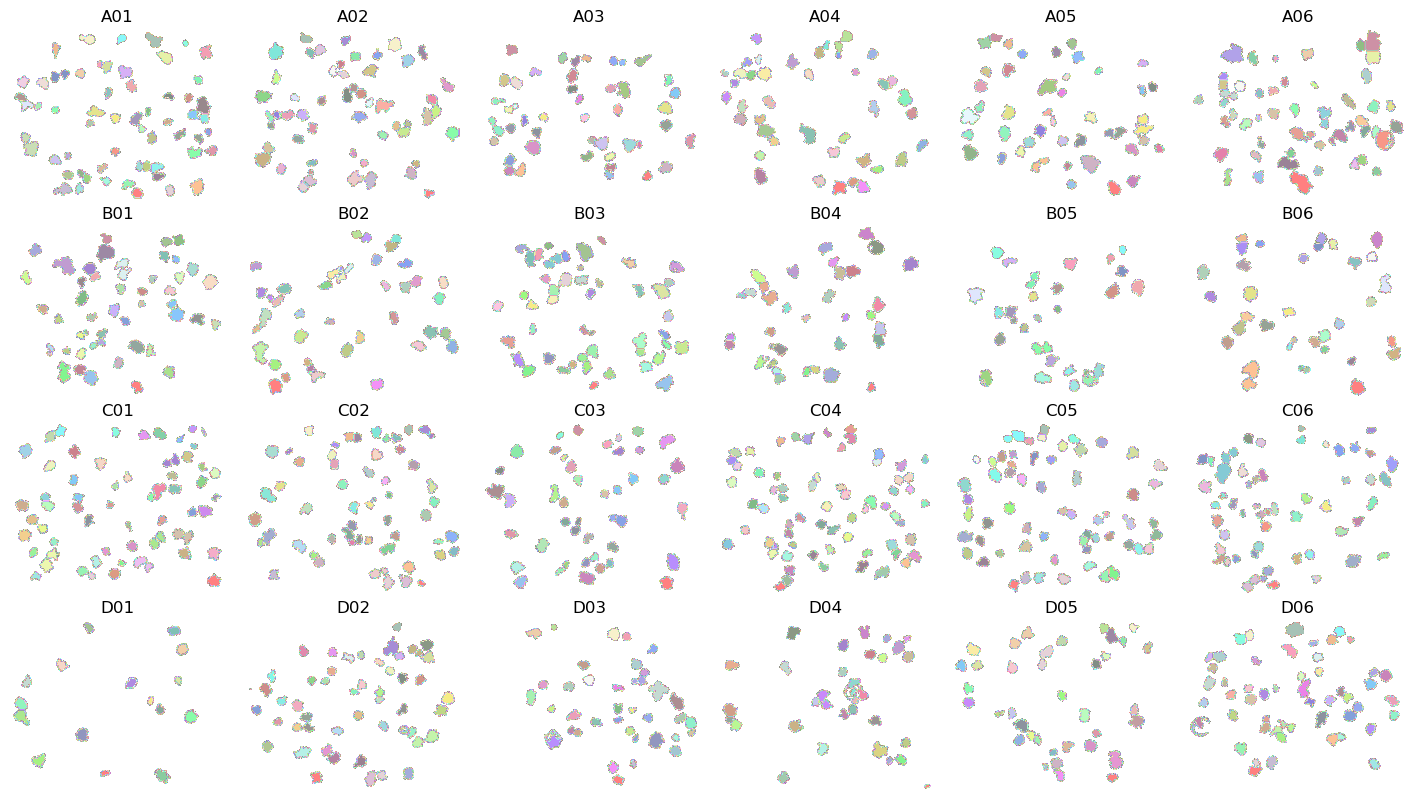

In [3]:
cmap = random_cmap()

plot_plate(
    resolution=plot_resolution,
    output_path="./output/organoid_object_plot.tif",
    img_folder_path="./output/segmented_organoids/",
    colormap=cmap
    )

Now let's do the same for the in-focus out-of-focus objects to see if we managed to detect them correctly across all wells.

In [4]:
# Define the directory path where your in-focus organoid z-stack have been stored ("./output/in_focus_organoids/" by default)
in_focus_organoids = Path("./output/in_focus_organoids/")

# segment_in_focus_organoids() returns a dictionary where the organoid labels are stored under each well_id key
segmented_in_focus_organoids = segment_in_focus_organoids(in_focus_organoids)

In [5]:
# Define the directory path where you want to save the segmented organoid masks
output_focus_directory = "./output/in_out_focus_masks/"

# Save the in-focus segmented organoid masks contained in segmented_in_focus_organoids in the above defined output directory
save_object_mask(segmented_in_focus_organoids, output_focus_directory)

By running the cell below you can visualize the segmented organoid focus mask in the same plateview as the greyscale images.

6it [00:00, 100.49it/s]
6it [00:00, 71.07it/s]
6it [00:00, 75.51it/s]
6it [00:00, 76.51it/s]


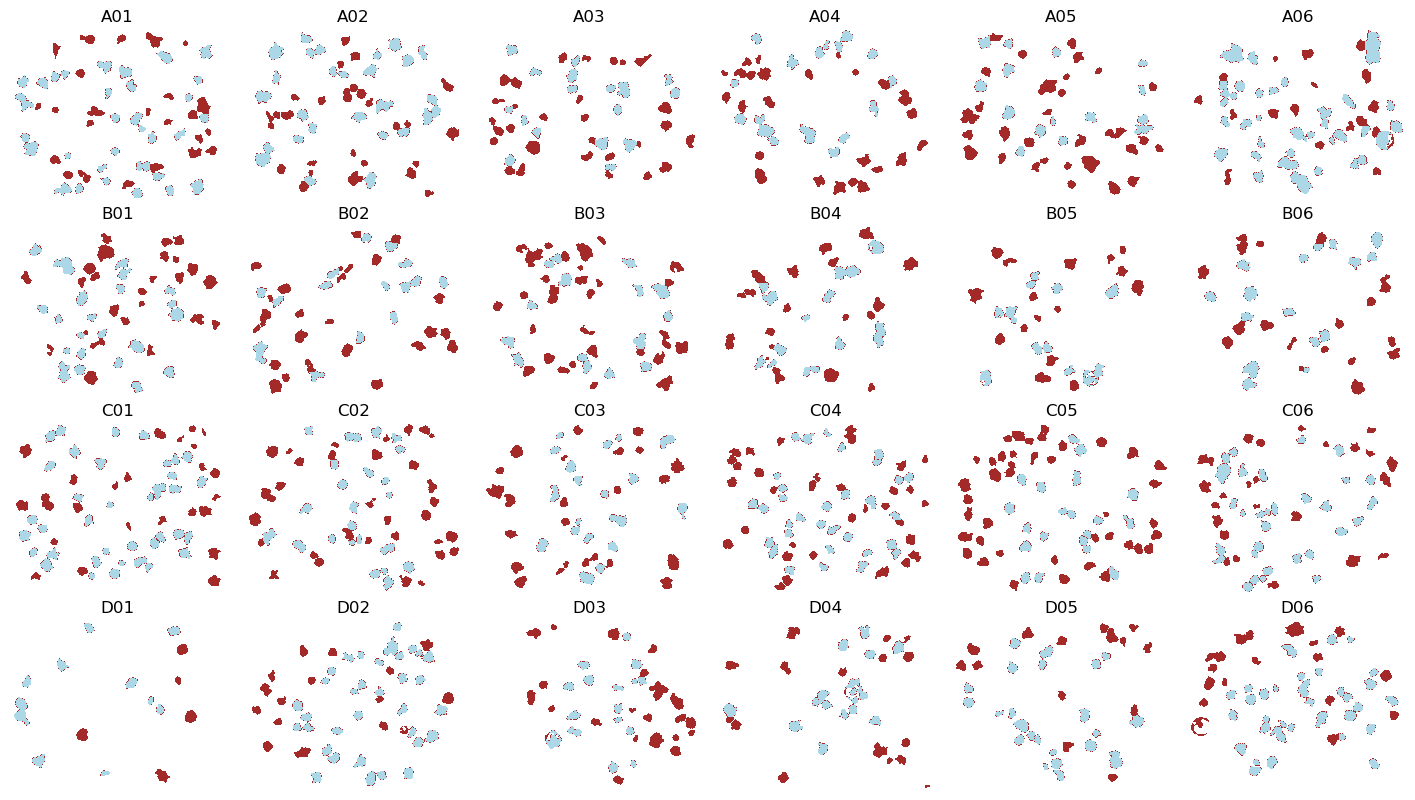

In [2]:
# Define the colors for each value
colors = [(0, 0, 0, 0),  # Transparent for 0
          (0.647, 0.165, 0.165, 1),  # Brown for 1 (out of focus)
          (0.678, 0.847, 0.902, 1)]  # Light blue for 2 (in focus)

# Create a colormap using ListedColormap
custom_cmap = ListedColormap(colors)

plot_plate(
    resolution=plot_resolution,
    output_path="./output/organoid_focus_masks_plot.tif",
    img_folder_path="./output/in_out_focus_masks/",
    colormap=custom_cmap
    )

<h2>Napari visualization</h2>
By running the cells below you should be able to explore the greyscale images and segmentations layered on top of each other to fine tune your pipeline at a plate scale

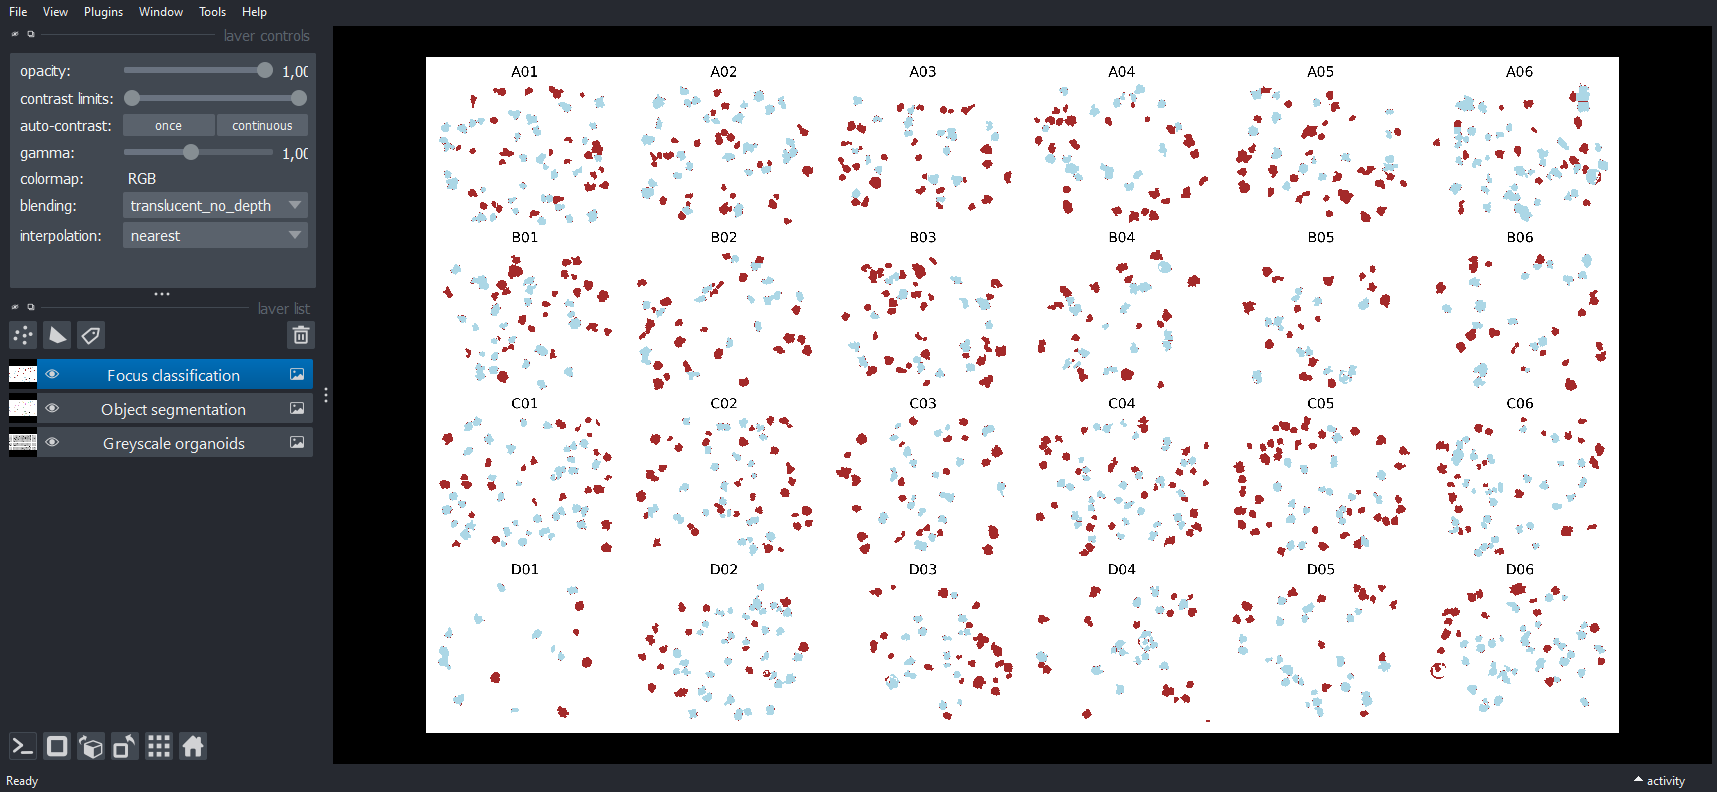

In [3]:
greyscale_plate = tifffile.imread("./output/output_plot.tif")
organoid_object_plate = tifffile.imread("./output/organoid_object_plot.tif")
in_focus_organoids_object_plate = tifffile.imread("./output/organoid_focus_masks_plot.tif")


viewer = napari.Viewer(ndisplay=2)
viewer.add_image(greyscale_plate, name="Greyscale organoids")
viewer.add_image(organoid_object_plate, name="Object segmentation")
viewer.add_image(in_focus_organoids_object_plate, name="Focus classification")
nbscreenshot(viewer)

Additionally you can explore the plate on a well per well basis i.e. <code>["A01"]</code> 

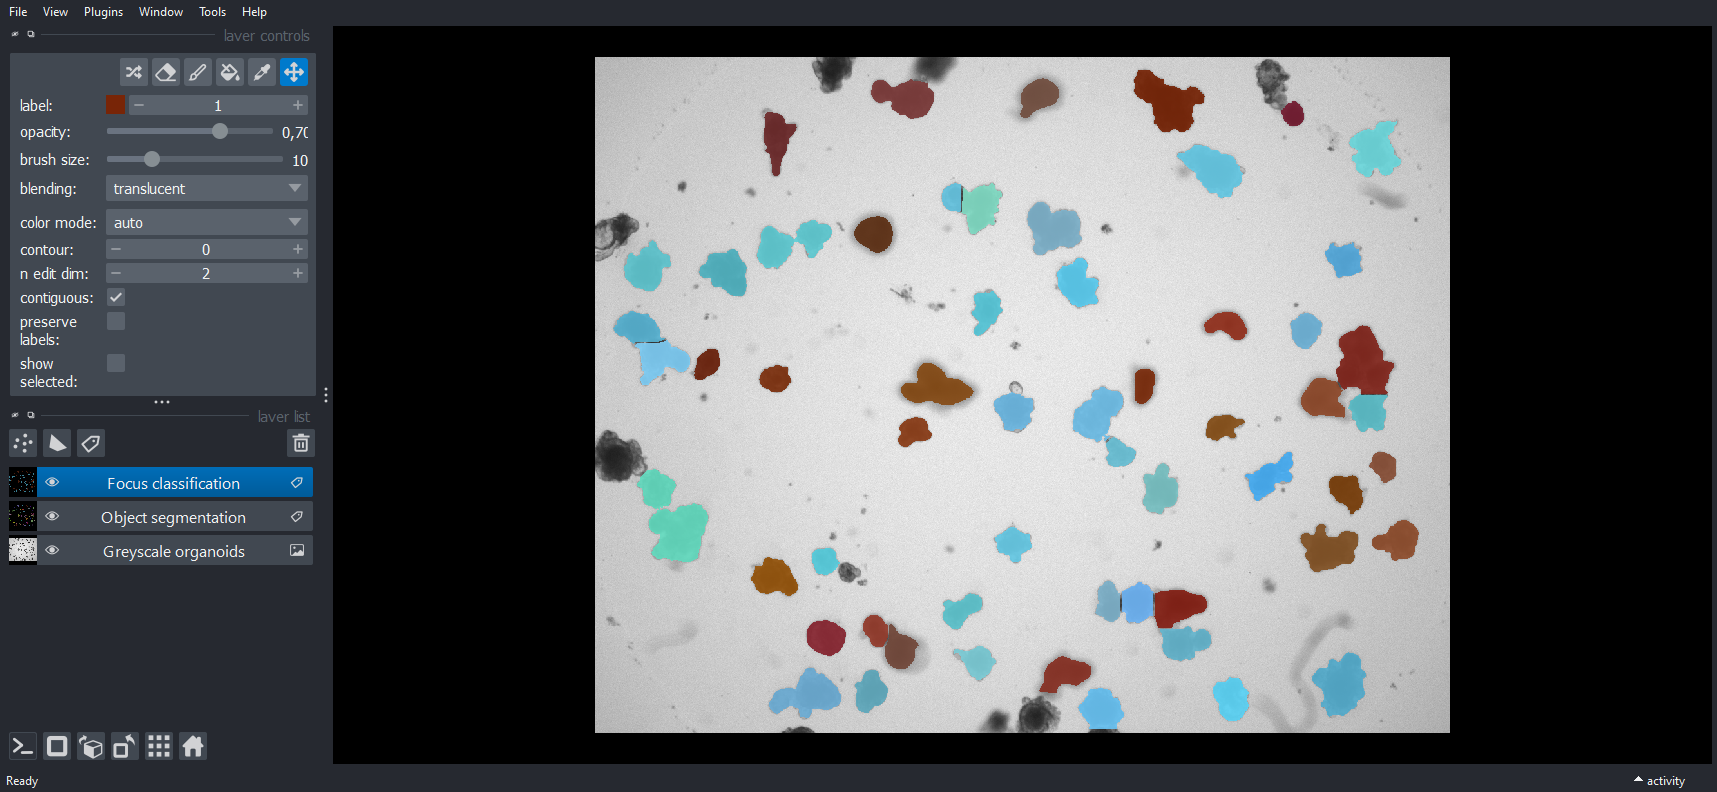

In [4]:
# Define the well you want to explore and hit run.
well_id = "A01"

greyscale = tifffile.imread(f"./output/in_focus_organoids/{well_id}.tif", is_ome=False)
organoid_object = tifffile.imread(f"./output/segmented_organoids/{well_id}.tif", is_ome=False)
organoid_focus = tifffile.imread(f"./output/in_out_focus_masks/{well_id}.tif", is_ome=False)

viewer = napari.Viewer(ndisplay=2)
viewer.add_image(greyscale, name="Greyscale organoids")
viewer.add_labels(organoid_object, name="Object segmentation")
viewer.add_labels(organoid_focus, name="Focus classification")
nbscreenshot(viewer)